11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ x (InputLayer)                  │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_z (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_hat (Dense)                   │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 437,664 (1.67 MB)

 Trainable params: 437,664 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0895 - val_loss: 0.0393
Epoch 2/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0372 - val_loss: 0.0315
Epoch 3/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0306 - val_loss: 0.0279
Epoch 4/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0274 - val_loss: 0.0256
Epoch 5/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0253 - val_loss: 0.0239
Epoch 6/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0239 - val_loss: 0.0231
Epoch 7/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0228 - val_loss: 0.0221
Epoch 8/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0220 - val_loss: 0.0215
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


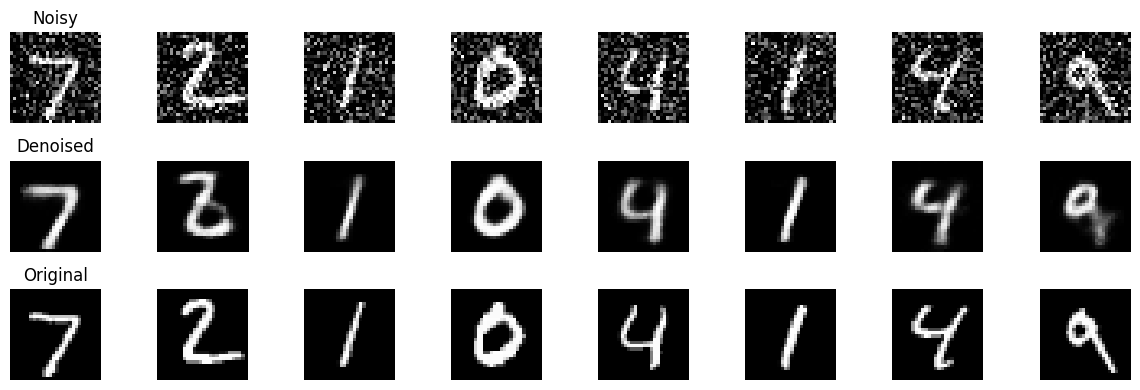

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model

# 1) Load MNIST
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Flatten images: 28x28 -> 784
x_train_flat = x_train.reshape((-1, 784))
x_test_flat  = x_test.reshape((-1, 784))

# 2) Create noisy inputs (simple application: denoising)
noise_factor = 0.35
x_train_noisy = x_train_flat + noise_factor * np.random.randn(*x_train_flat.shape)
x_test_noisy  = x_test_flat  + noise_factor * np.random.randn(*x_test_flat.shape)

# Clip to valid range [0,1]
x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy  = np.clip(x_test_noisy, 0.0, 1.0)

# 3) Build Autoencoder
input_dim = 784
latent_dim = 16

inp = layers.Input(shape=(input_dim,), name="x")

# Encoder
h1 = layers.Dense(256, activation="relu")(inp)
h2 = layers.Dense(64, activation="relu")(h1)
z  = layers.Dense(latent_dim, activation="relu", name="latent_z")(h2)

# Decoder
h3 = layers.Dense(64, activation="relu")(z)
h4 = layers.Dense(256, activation="relu")(h3)
out = layers.Dense(input_dim, activation="sigmoid", name="x_hat")(h4)

autoencoder = Model(inp, out, name="Autoencoder")
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.summary()

# 4) Train: noisy -> clean
history = autoencoder.fit(
    x_train_noisy, x_train_flat,
    epochs=8,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test_noisy, x_test_flat),
    verbose=1
)

# 5) Reconstruct (denoise)
decoded = autoencoder.predict(x_test_noisy)

# 6) Visualize results: Noisy vs Denoised vs Original
n = 8
plt.figure(figsize=(12, 4))

for i in range(n):
    # Noisy
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
    if i == 0: ax.set_title("Noisy")

    # Denoised
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
    if i == 0: ax.set_title("Denoised")

    # Original
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test_flat[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
    if i == 0: ax.set_title("Original")

plt.tight_layout()
plt.show()